In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable 
import torchvision
from torchvision import transforms
from torch import utils
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from tqdm import tqdm, notebook 
import matplotlib.pyplot as plt


In [15]:
import pycuda

ModuleNotFoundError: No module named 'pycuda'

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
use_cuda

False

In [3]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, n_hiden, first_hiden = None, center_hiden = None , last_hiden = 2): 
        if first_hiden == None:
            first_hiden = input_dim
        if center_hiden == None:
            center_hiden = first_hiden
        super(LogisticRegressionModel, self).__init__()
        self.leyer_list = nn.ModuleList()
        layer_w = input_dim
        hiden_dim = first_hiden
        for i in range(n_hiden+1):
            self.leyer_list.append(nn.Linear(layer_w, hiden_dim))
            if i < (n_hiden/2)-1:
                layer_w = hiden_dim
                hiden_dim = (int)((i+1)*(2*(center_hiden-first_hiden)/n_hiden)+first_hiden)
            else:
                layer_w = hiden_dim
                hiden_dim = (int)((i-n_hiden/2+1)*(2*(last_hiden-center_hiden)/n_hiden)+center_hiden)
        self.leyer_list.append(nn.Linear(layer_w, 1))
    def forward(self, x): 
        Relu = nn.LeakyReLU()
        Sigm = nn.Sigmoid()
        for layer in self.leyer_list[:-1]:
            x = Relu(layer(x))
        y = Sigm(self.leyer_list[-1](x))
        return y

In [4]:
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels):
        'Initialization'
        self.labels = labels
        self.features = features

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

    def __getitem__(self, index):
        'Generates one sample of data'
        x = self.features[index]
        y = self.labels[index]
        return x, y


In [5]:
def acc(features, targets):
    targets = targets.to(device).view(-1,1).detach()
    outputs = model(features.to(device)).detach()
    loss_eval = loss_fun(outputs, targets)
    pred = (outputs>0.5).float()
    precision = precision_score(pred, targets)
    recal = recall_score(pred, targets)
    pred = (pred.to(device) == targets).sum()
    return pred.float()/len(outputs), loss_eval.detach(), precision, recal

In [6]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,3, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["train_loss"]))
    ax[0].plot(x, run_hist["train_loss"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["test_loss"],'r', marker='.', label="test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train_acc"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["test_acc"],'r', marker='.', label="test accuracy")
    ax[1].legend()
    ax[2].plot(x, run_hist["train_precision"],'b', marker='.', label="train precision")
    ax[2].plot(x, run_hist["test_precision"],'r', marker='.', label="test precision")
    ax[2].legend()

In [7]:
def plot_roc(x, y, model):
    output = model(x.to(device))
    fpr, tpr, thresholds = roc_curve(y.cpu().detach().numpy(), output.cpu().detach().numpy())
    plt.figure()
    lw = 2
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc_val

In [8]:
train_data_file = "~/data2.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["Unnamed: 0", "eventID", "track_particle_key", "track_position_z", "track_ghostProbability"] , axis=1).astype(np.float64)
targets = np.array([(is_down and down_in_velo) for is_down, down_in_velo in zip(data.particle_isDown_noVelo.values, data.particle_isDown.values)]).astype(np.float64)
features = features.drop(["particle_isDown_noVelo", "particle_isDown", features.columns[0]], axis=1).values

In [9]:
scaler = StandardScaler()
scaler.fit(features)
X = scaler.transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size = 0.2)
print(X[0])

[ 0.81191971  0.6338766   0.71733389 -0.18177026  1.40834098  0.60525883
  0.74897471  0.64184725  2.42420699 -0.35173992 -1.21397115  1.71551782
 -0.86323825]


In [10]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [11]:
epochs = 301
batch_size = 10000
input_dim = X_train.shape[1]
output_dim = 1
lr_rate = 0.05
n_hiden = 7
first_hiden = 18
center_hiden = 13
last_hiden = 5
params = [n_hiden, first_hiden, center_hiden, last_hiden]
training_set = Dataset(X_train, y_train)
training_generator = utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)

In [12]:
model = LogisticRegressionModel(input_dim, *params)
print(model)

LogisticRegressionModel(
  (leyer_list): ModuleList(
    (0): Linear(in_features=13, out_features=18, bias=True)
    (1): Linear(in_features=18, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=13, bias=True)
    (4): Linear(in_features=13, out_features=11, bias=True)
    (5): Linear(in_features=11, out_features=9, bias=True)
    (6): Linear(in_features=9, out_features=7, bias=True)
    (7): Linear(in_features=7, out_features=5, bias=True)
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


n_hiden: 7, first_hiden: 18, center_hiden: 13 last_hiden: 5


/home/halaka/pytorch-env/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


epoch 1
train: loss 1.2228, acc = 0.8567, precision= 0.0000, recal= 0.0000
test:  loss 1.2192, acc = 0.8584, precision = 0.0000, recal= 0.0000
epoch 2
train: loss 1.1844, acc = 0.8567, precision= 0.0000, recal= 0.0000
test:  loss 1.1789, acc = 0.8584, precision = 0.0000, recal= 0.0000
epoch 3
train: loss 1.1714, acc = 0.8567, precision= 0.0000, recal= 0.0000
test:  loss 1.1671, acc = 0.8584, precision = 0.0000, recal= 0.0000
epoch 4
train: loss 1.1668, acc = 0.7778, precision= 0.2441, recal= 0.2348
test:  loss 1.1625, acc = 0.7792, precision = 0.2388, recal= 0.2303
epoch 5
train: loss 1.1663, acc = 0.8435, precision= 0.0550, recal= 0.2716
test:  loss 1.1618, acc = 0.8458, precision = 0.0522, recal= 0.2703
epoch 6
train: loss 1.1637, acc = 0.7565, precision= 0.3160, recal= 0.2372
test:  loss 1.1594, acc = 0.7591, precision = 0.3161, recal= 0.2370
epoch 7
train: loss 1.1637, acc = 0.7996, precision= 0.2053, recal= 0.2536
test:  loss 1.1589, acc = 0.8018, precision = 0.2072, recal= 0.2545

epoch 58
train: loss 1.1196, acc = 0.7859, precision= 0.4585, recal= 0.3249
test:  loss 1.1188, acc = 0.7829, precision = 0.4538, recal= 0.3150
epoch 59
train: loss 1.1215, acc = 0.7754, precision= 0.4770, recal= 0.3135
test:  loss 1.1212, acc = 0.7734, precision = 0.4691, recal= 0.3049
epoch 60
train: loss 1.1210, acc = 0.7822, precision= 0.4583, recal= 0.3190
test:  loss 1.1220, acc = 0.7780, precision = 0.4502, recal= 0.3067
epoch 61
train: loss 1.1216, acc = 0.7936, precision= 0.4300, recal= 0.3306
test:  loss 1.1215, acc = 0.7910, precision = 0.4271, recal= 0.3211
epoch 62
train: loss 1.1199, acc = 0.7790, precision= 0.4719, recal= 0.3175
test:  loss 1.1212, acc = 0.7760, precision = 0.4614, recal= 0.3067
epoch 63
train: loss 1.1187, acc = 0.7855, precision= 0.4647, recal= 0.3257
test:  loss 1.1195, acc = 0.7826, precision = 0.4561, recal= 0.3152
epoch 64
train: loss 1.1187, acc = 0.7793, precision= 0.4811, recal= 0.3201
test:  loss 1.1200, acc = 0.7745, precision = 0.4695, recal=

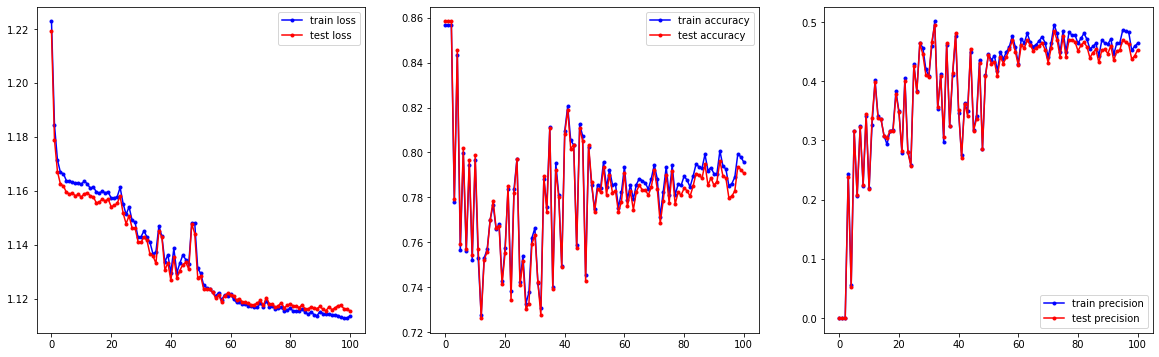

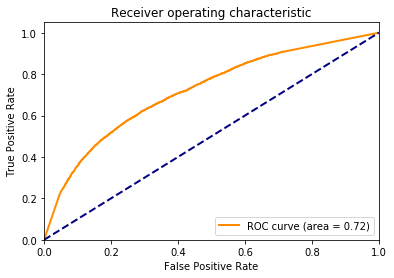

epoch 102
train: loss 1.1123, acc = 0.8005, precision= 0.4554, recal= 0.3493
test:  loss 1.1146, acc = 0.7956, precision = 0.4442, recal= 0.3335
epoch 103
train: loss 1.1121, acc = 0.7976, precision= 0.4643, recal= 0.3462
test:  loss 1.1145, acc = 0.7926, precision = 0.4500, recal= 0.3297
epoch 104
train: loss 1.1122, acc = 0.8004, precision= 0.4558, recal= 0.3494
test:  loss 1.1146, acc = 0.7953, precision = 0.4419, recal= 0.3323
epoch 105
train: loss 1.1119, acc = 0.7966, precision= 0.4670, recal= 0.3449
test:  loss 1.1151, acc = 0.7913, precision = 0.4529, recal= 0.3283
epoch 106
train: loss 1.1116, acc = 0.8005, precision= 0.4565, recal= 0.3496
test:  loss 1.1148, acc = 0.7954, precision = 0.4473, recal= 0.3339
epoch 107
train: loss 1.1116, acc = 0.7946, precision= 0.4729, recal= 0.3428
test:  loss 1.1152, acc = 0.7899, precision = 0.4574, recal= 0.3270
epoch 108
train: loss 1.1115, acc = 0.7982, precision= 0.4642, recal= 0.3471
test:  loss 1.1143, acc = 0.7940, precision = 0.4538,

epoch 159
train: loss 1.1089, acc = 0.7961, precision= 0.4784, recal= 0.3466
test:  loss 1.1154, acc = 0.7893, precision = 0.4558, recal= 0.3256
epoch 160
train: loss 1.1089, acc = 0.7958, precision= 0.4795, recal= 0.3463
test:  loss 1.1153, acc = 0.7891, precision = 0.4565, recal= 0.3254
epoch 161
train: loss 1.1088, acc = 0.7963, precision= 0.4788, recal= 0.3471
test:  loss 1.1154, acc = 0.7894, precision = 0.4549, recal= 0.3257
epoch 162
train: loss 1.1089, acc = 0.7960, precision= 0.4790, recal= 0.3465
test:  loss 1.1153, acc = 0.7894, precision = 0.4558, recal= 0.3259
epoch 163
train: loss 1.1088, acc = 0.7967, precision= 0.4777, recal= 0.3475
test:  loss 1.1154, acc = 0.7898, precision = 0.4534, recal= 0.3259
epoch 164
train: loss 1.1088, acc = 0.7961, precision= 0.4791, recal= 0.3467
test:  loss 1.1154, acc = 0.7893, precision = 0.4540, recal= 0.3252
epoch 165
train: loss 1.1088, acc = 0.7960, precision= 0.4786, recal= 0.3466
test:  loss 1.1153, acc = 0.7892, precision = 0.4552,

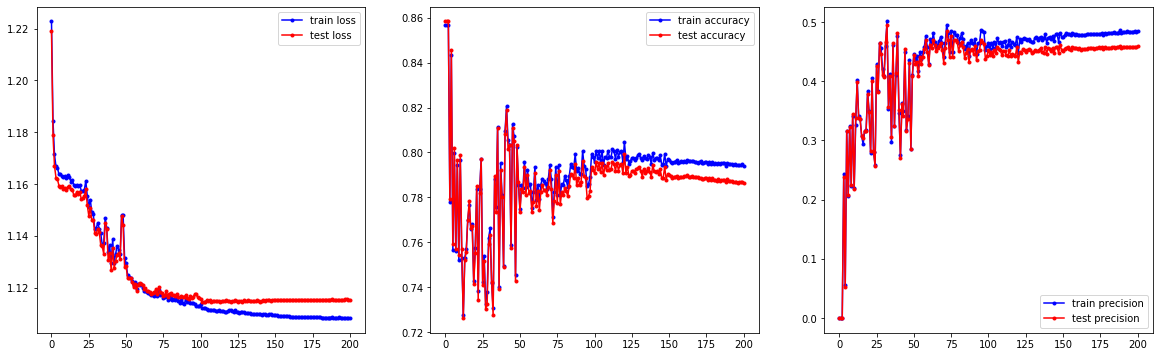

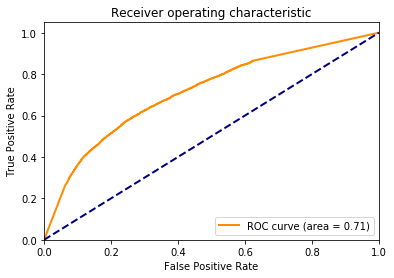

epoch 202
train: loss 1.1083, acc = 0.7941, precision= 0.4850, recal= 0.3447
test:  loss 1.1154, acc = 0.7868, precision = 0.4587, recal= 0.3224
epoch 203
train: loss 1.1083, acc = 0.7943, precision= 0.4842, recal= 0.3449
test:  loss 1.1154, acc = 0.7868, precision = 0.4578, recal= 0.3221
epoch 204
train: loss 1.1083, acc = 0.7941, precision= 0.4851, recal= 0.3447
test:  loss 1.1154, acc = 0.7865, precision = 0.4590, recal= 0.3220
epoch 205
train: loss 1.1083, acc = 0.7942, precision= 0.4850, recal= 0.3448
test:  loss 1.1154, acc = 0.7866, precision = 0.4587, recal= 0.3220
epoch 206
train: loss 1.1083, acc = 0.7941, precision= 0.4848, recal= 0.3445
test:  loss 1.1154, acc = 0.7866, precision = 0.4585, recal= 0.3220
epoch 207
train: loss 1.1083, acc = 0.7943, precision= 0.4848, recal= 0.3449
test:  loss 1.1154, acc = 0.7866, precision = 0.4587, recal= 0.3221
epoch 208
train: loss 1.1083, acc = 0.7943, precision= 0.4852, recal= 0.3450
test:  loss 1.1155, acc = 0.7866, precision = 0.4587,

epoch 259
train: loss 1.1081, acc = 0.7938, precision= 0.4872, recal= 0.3447
test:  loss 1.1154, acc = 0.7859, precision = 0.4596, recal= 0.3211
epoch 260
train: loss 1.1081, acc = 0.7938, precision= 0.4873, recal= 0.3447
test:  loss 1.1154, acc = 0.7858, precision = 0.4594, recal= 0.3209
epoch 261
train: loss 1.1081, acc = 0.7938, precision= 0.4872, recal= 0.3446
test:  loss 1.1154, acc = 0.7858, precision = 0.4594, recal= 0.3210
epoch 262
train: loss 1.1081, acc = 0.7938, precision= 0.4873, recal= 0.3446
test:  loss 1.1154, acc = 0.7858, precision = 0.4594, recal= 0.3210
epoch 263
train: loss 1.1081, acc = 0.7938, precision= 0.4872, recal= 0.3446
test:  loss 1.1154, acc = 0.7858, precision = 0.4594, recal= 0.3209
epoch 264
train: loss 1.1081, acc = 0.7938, precision= 0.4873, recal= 0.3446
test:  loss 1.1154, acc = 0.7858, precision = 0.4594, recal= 0.3209
epoch 265
train: loss 1.1081, acc = 0.7938, precision= 0.4873, recal= 0.3446
test:  loss 1.1154, acc = 0.7858, precision = 0.4594,

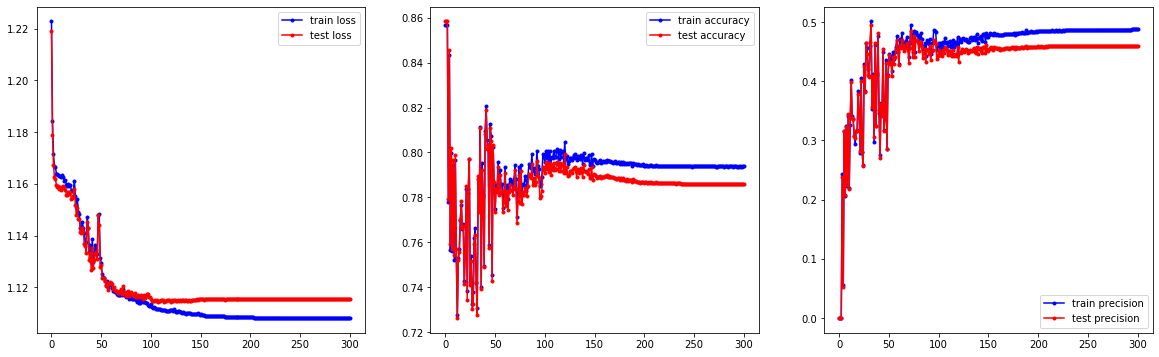

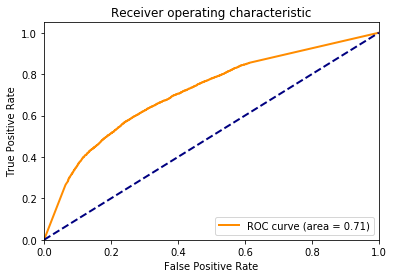

In [13]:
stat_dict = {
    "train_loss" : [],
    "test_loss" : [],
    "train_acc" : [],
    "test_acc" : [],
    "train_precision" : [],
    "test_precision" : [],
    "train_recal" : [],
    "test_recal" : []
}
print("n_hiden: {}, first_hiden: {}, center_hiden: {} last_hiden: {}".format(*params))

pos_weight=torch.FloatTensor([134976/22509])
loss_fun = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr_rate)

model.to(device)
n_epoch = len(stat_dict["train_acc"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)
for epoch in range(n_epoch, epochs):
    train_acc, train_loss, train_precision, train_recal= acc(X_train, y_train)
    test_acc, test_loss, test_precision, test_recal = acc(X_test, y_test)
    for batch_features, batch_targets in training_generator:
        batch_features, batch_targets = batch_features.to(device).view(-1,input_dim), batch_targets.to(device).view(-1,1)
        def closure(batch_features, batch_targets):
            optimizer.zero_grad()
            pred = model(batch_features)
            loss_val = loss_fun(pred, batch_targets)
            loss_val.backward()
        optimizer.step(closure(batch_features, batch_targets))
        optimizer.zero_grad()
    scheduler.step()
    stat_dict["test_loss"].append(test_loss)
    stat_dict["test_acc"].append(test_acc)
    stat_dict["test_precision"].append(test_precision)
    stat_dict["test_recal"].append(test_recal)
    
    stat_dict["train_loss"].append(train_loss)    
    stat_dict["train_acc"].append(train_acc)
    stat_dict["train_precision"].append(train_precision)    
    stat_dict["train_recal"].append(train_recal)
    print("epoch {0}".format(epoch+1))
    print("train: loss {0:.4f}, acc = {1:.4f}, precision= {2:.4f}, recal= {3:.4f}".format(train_loss, train_acc, train_precision, train_recal))
    print("test:  loss {0:.4f}, acc = {1:.4f}, precision = {2:.4f}, recal= {3:.4f}".format( test_loss, test_acc, test_precision, test_recal))
    if epoch!=0 and epoch%100==0:
        plot_training_classification(stat_dict)
        auc_val = plot_roc(X_test, y_test, model)


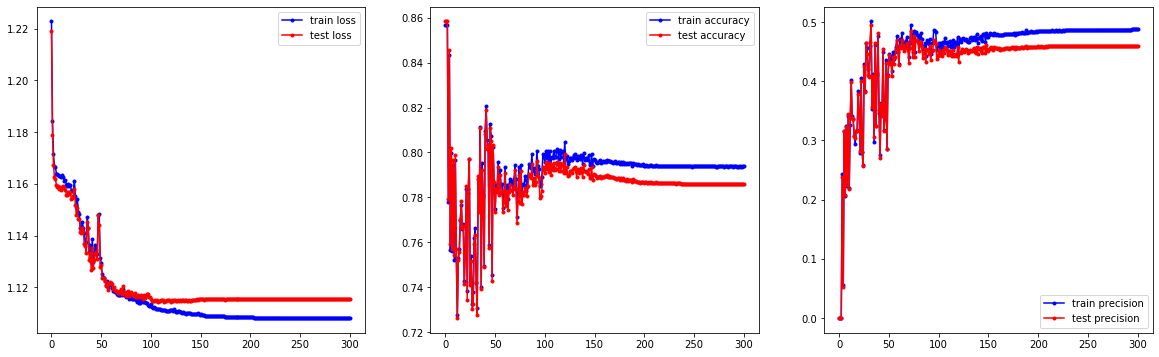

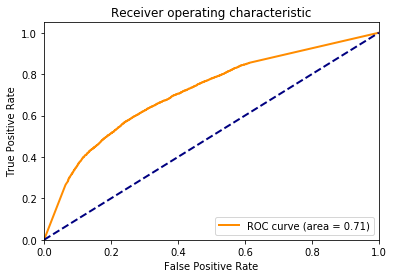

In [14]:
plot_training_classification(stat_dict)
auc_val = plot_roc(X_test, y_test, model)